#### Read data

In [1]:
import sframe
import numpy as np

loans = sframe.SFrame('data1/')

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1502952639.log


#### Get target and feature

In [2]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

#### Make dataset balanced

In [3]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502236174422
Percentage of risky loans                : 0.497763825578
Total number of loans in our new dataset : 46508


#### One-hot encoding

In [4]:
loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

In [5]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable
features


['grade.A',
 'grade.B',
 'grade.C',
 'grade.D',
 'grade.E',
 'grade.F',
 'grade.G',
 'term. 36 months',
 'term. 60 months',
 'home_ownership.MORTGAGE',
 'home_ownership.OTHER',
 'home_ownership.OWN',
 'home_ownership.RENT',
 'emp_length.1 year',
 'emp_length.10+ years',
 'emp_length.2 years',
 'emp_length.3 years',
 'emp_length.4 years',
 'emp_length.5 years',
 'emp_length.6 years',
 'emp_length.7 years',
 'emp_length.8 years',
 'emp_length.9 years',
 'emp_length.< 1 year',
 'emp_length.n/a']

#### Train test split

In [6]:
train_data, test_data = loans_data.random_split(0.8,seed=1)

#### Function to return weighted mistake in a node

In [28]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    if weighted_mistakes_all_positive > weighted_mistakes_all_negative:
        return (weighted_mistakes_all_negative,-1)
    else:
        return (weighted_mistakes_all_positive,+1)

In [29]:
example_labels = sframe.SArray([-1, -1, 1, 1, 1])
example_data_weights = sframe.SArray([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


#### Function to pick the best feature

In [35]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target],left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target],right_data_weights)
        
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / float(sum(data_weights))
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [36]:
example_data_weights = sframe.SArray(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term. 36 months':
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test passed!


#### Function to create leaf

In [39]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

In [40]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [41]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [43]:
example_data_weights = sframe.SArray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade.A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade.D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data po

In [44]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade.A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade.D'},
 'splitting_feature': 'term. 36 months'}

#### Make predictions 

In [45]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

#### Evaluate the tree

In [46]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [47]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

#### Adaboost classifier

In [82]:
a = sframe.SArray([1.]*10)
a+a

dtype: float
Rows: 10
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [105]:
from math import log
from math import exp

def adaboost_with_tree_stumps(data,feature,target,num_tree_stumps):
    alpha = sframe.SArray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='
        
        tree_stump = weighted_decision_tree_create(data,features,target,data_weights = alpha,max_depth = 1)
        tree_stumps.append(tree_stump)
        
        predictions = data.apply(lambda x: classify(tree_stump,x))
        
        is_correct = predictions == target_values
        is_wrong = predictions != target_values
        
        
        weighted_error = sum(alpha[is_wrong == True]) / float(sum(alpha))
        weight = log((1-weighted_error)/float(weighted_error)) / 2
        weights.append(weight)
        
        adjustment = is_correct.apply(lambda is_correct: exp(-weight) if is_correct else exp(weight))
        alpha = alpha*sframe.SArray(adjustment)
        alpha = alpha/float(sum(alpha))
    return weights, tree_stumps

In [106]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.


#### Function to print the tree

In [66]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       root'
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [107]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]            [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [108]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]                    [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [109]:
print stump_weights

[0.15802933659263743, 0.1768236329364191]


#### Train a boosted ensemble of 10 stumps

In [110]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

#### Make predictions

In [147]:
a = sframe.SArray([1,2])
list(a)

[1, 2]

In [143]:
def predict_adaboost(stump_weights,tree_stumps,data):
    scores = sframe.SArray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump,x))
        scores = scores+predictions*stump_weights[i]
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [148]:
from sklearn.metrics import accuracy_score
predictions = predict_adaboost(stump_weights,tree_stumps,test_data)
accuracy_score(list(test_data[target]),list(predictions))

0.62031451960361916

#### Performance Plot

In [149]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term. 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
---------------------------------

Split on feature emp_length.n/a. (35781, 1443)
--------------------------------------------------------------------
Subtree, depth = 2 (35781 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1443 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 15
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 16
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.A. (32094, 5130)
-------------

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature grade.C. (27812, 9412)
--------------------------------------------------------------------
Subtree, depth = 2 (27812 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (9412 data points).
Reached maximum depth. Stopping for now.


In [151]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - accuracy_score(list(train_data[target]), list(predictions))
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.433430045132
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.384724908661
Iteration 6, training error = 0.384617451107
Iteration 7, training error = 0.382763808296
Iteration 8, training error = 0.384617451107
Iteration 9, training error = 0.382763808296
Iteration 10, training error = 0.384483129164
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.381447453256
Iteration 13, training error = 0.381528046422
Iteration 14, training error = 0.380560928433
Iteration 15, training error = 0.380507199656
Iteration 16, training error = 0.378223726628
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378411777348
Iteration 19, training error = 0.378062540297
Iteration 20, training error = 0.378761014399
Iteration 21, training error = 0.379566946056
Iteration 22, training error = 0.3788953363

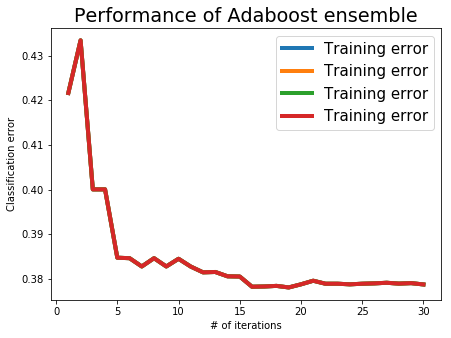

In [158]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})
plt.show()

#### Evaluate on test data

In [160]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - accuracy_score(list(test_data[target]), list(predictions))
    test_error_all.append(error)
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.428479103835
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.379900904782
Iteration 6, test error = 0.380008616975
Iteration 7, test error = 0.379254631624
Iteration 8, test error = 0.380008616975
Iteration 9, test error = 0.379254631624
Iteration 10, test error = 0.379685480396
Iteration 11, test error = 0.379254631624
Iteration 12, test error = 0.377962085308
Iteration 13, test error = 0.379254631624
Iteration 14, test error = 0.377854373115
Iteration 15, test error = 0.378500646273
Iteration 16, test error = 0.377854373115
Iteration 17, test error = 0.377962085308
Iteration 18, test error = 0.377854373115
Iteration 19, test error = 0.378177509694
Iteration 20, test error = 0.376884963378
Iteration 21, test error = 0.377531236536
Iteration 22, test error = 0.376777251185
Iteration 23, test error = 0.376777251185
Iteration 24, test error = 0.376884963378
It

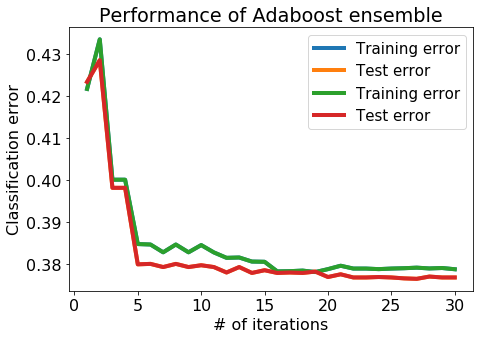

In [162]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()
plt.show()